In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

np.random.seed(42)


In [ ]:
def get_data_split(X, y, train_ratio=0.6, val_ratio=0.2):
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []

    for c in np.unique(y):
        idx = np.where(y == c)[0]
        X_c, y_c = X[idx], y[idx]

        perm = np.random.permutation(len(X_c))
        X_c, y_c = X_c[perm], y_c[perm]

        n = len(X_c)
        n_train = int(train_ratio * n)
        n_val = int(val_ratio * n)

        X_train.append(X_c[:n_train])
        y_train.append(y_c[:n_train])
        X_val.append(X_c[n_train:n_train+n_val])
        y_val.append(y_c[n_train:n_train+n_val])
        X_test.append(X_c[n_train+n_val:])
        y_test.append(y_c[n_train+n_val:])

    return (np.vstack(X_train), np.hstack(y_train),
            np.vstack(X_val), np.hstack(y_val),
            np.vstack(X_test), np.hstack(y_test))


In [ ]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]


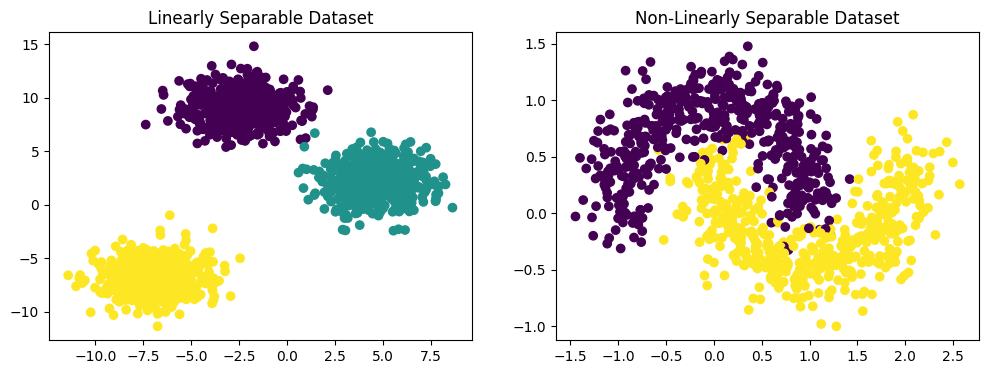

In [ ]:
# Dataset-1: Linearly separable (3 classes)
X1, y1 = make_blobs(n_samples=1500, centers=3, n_features=2,
                    cluster_std=1.5, random_state=42)

# Dataset-2: Non-linearly separable (2 classes)
X2, y2 = make_moons(n_samples=1000, noise=0.2, random_state=42)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(X1[:,0], X1[:,1], c=y1)
plt.title("Linearly Separable Dataset")

plt.subplot(1,2,2)
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.title("Non-Linearly Separable Dataset")
plt.show()


In [ ]:
class FCNN:
    def __init__(self, layers, lr=0.01):
        self.layers = layers
        self.lr = lr
        self.weights = []
        self.biases = []

        for i in range(len(layers)-1):
            self.weights.append(np.random.randn(layers[i], layers[i+1]) * 0.1)
            self.biases.append(np.zeros((1, layers[i+1])))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def forward(self, x):
        activations = [x.reshape(1,-1)]
        for W, b in zip(self.weights, self.biases):
            z = activations[-1] @ W + b
            activations.append(self.sigmoid(z))
        return activations

    def train_sgd(self, X, y, X_val, y_val, epochs=50):
        num_classes = self.layers[-1]
        train_err, val_err = [], []

        for ep in range(epochs):
            loss = 0
            idx = np.random.permutation(len(X))

            for i in idx:
                x = X[i]
                t = one_hot_encode(np.array([y[i]]), num_classes)

                A = self.forward(x)
                out = A[-1]
                error = out - t
                loss += np.sum(error**2)

                deltas = [error * self.sigmoid_derivative(out)]

                for l in range(len(self.weights)-1, 0, -1):
                    deltas.append(deltas[-1] @ self.weights[l].T *
                                  self.sigmoid_derivative(A[l]))
                deltas.reverse()

                for l in range(len(self.weights)):
                    self.weights[l] -= self.lr * A[l].T @ deltas[l]
                    self.biases[l] -= self.lr * deltas[l]

            train_err.append(loss / len(X))

            v_loss = 0
            for i in range(len(X_val)):
                o = self.forward(X_val[i])[-1]
                t = one_hot_encode(np.array([y_val[i]]), num_classes)
                v_loss += np.sum((o - t)**2)
            val_err.append(v_loss / len(X_val))

        return train_err, val_err

    def predict(self, X):
        return np.array([np.argmax(self.forward(x)[-1]) for x in X])


In [ ]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,300),
                         np.linspace(y_min,y_max,300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k')
    plt.title(title)
    plt.show()


In [ ]:
def plot_confusion(cm, title):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
def plot_3d_nodes(model, X, title):
    xx, yy = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 20),
                         np.linspace(X[:,1].min(), X[:,1].max(), 20))
    grid = np.c_[xx.ravel(), yy.ravel()]

    acts = [model.forward(p) for p in grid]

    for l in range(len(model.weights)):
        layer_out = np.array([a[l+1].flatten() for a in acts])
        fig = plt.figure(figsize=(12,4))
        for n in range(min(3, layer_out.shape[1])):
            ax = fig.add_subplot(1,3,n+1, projection='3d')
            ax.plot_surface(xx, yy, layer_out[:,n].reshape(xx.shape))
            ax.set_title(f"Layer {l+1} Node {n+1}")
        plt.suptitle(title)
        plt.show()



===== Linear Dataset =====
Architecture: [2, 5, 3]
Validation Accuracy: 1.0
Architecture: [2, 10, 3]
Validation Accuracy: 1.0


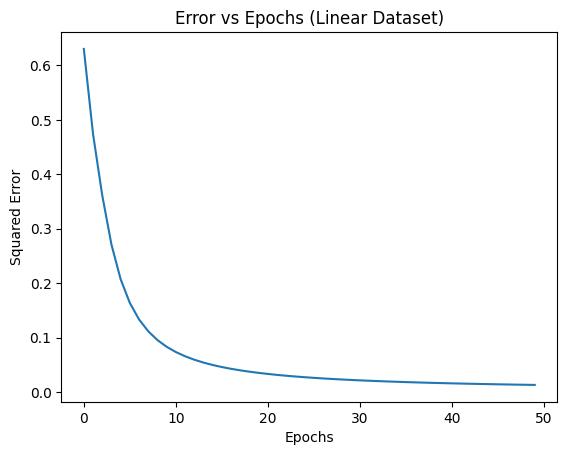

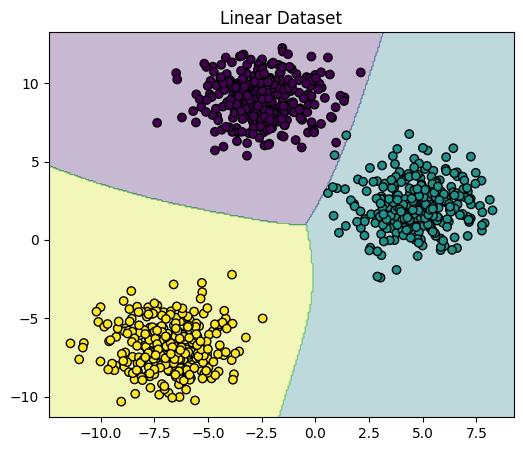

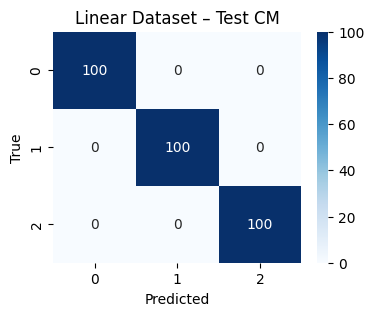

Test Accuracy: 1.0


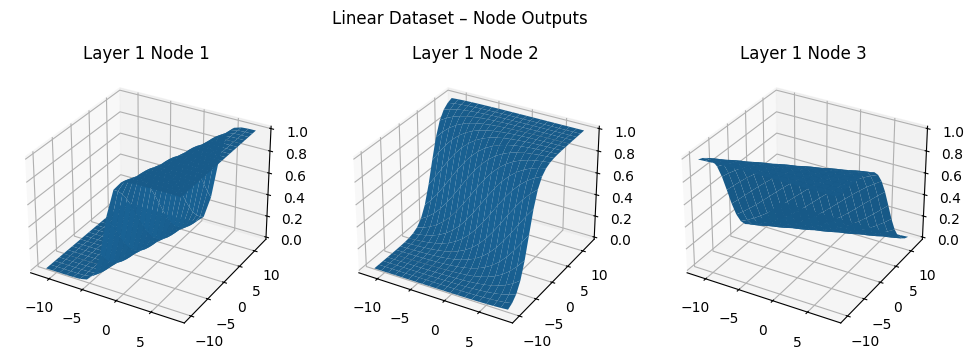

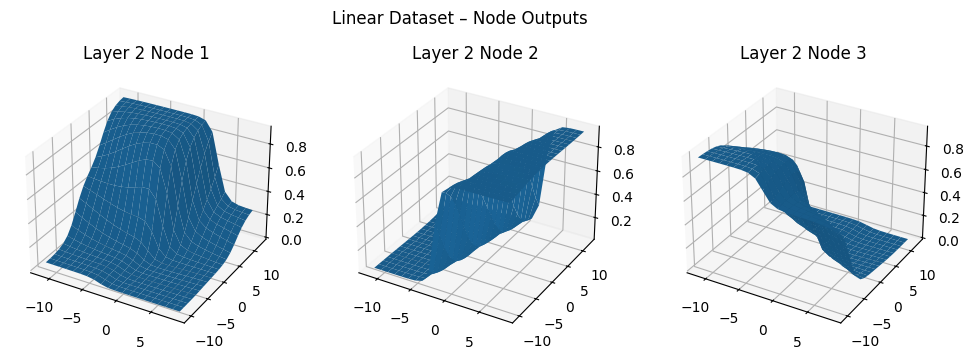


===== Nonlinear Dataset =====
Architecture: [2, 8, 8, 2]
Validation Accuracy: 0.5
Architecture: [2, 16, 16, 2]
Validation Accuracy: 0.585


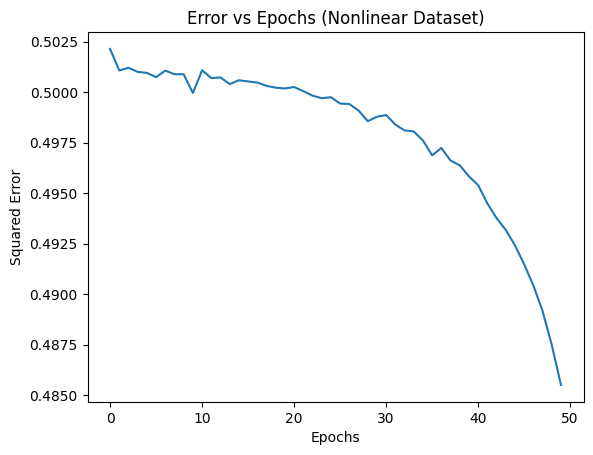

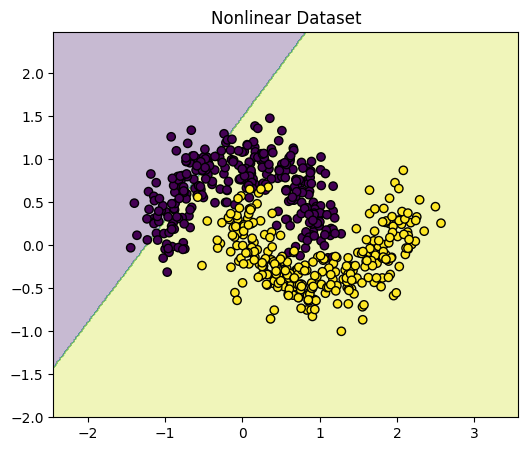

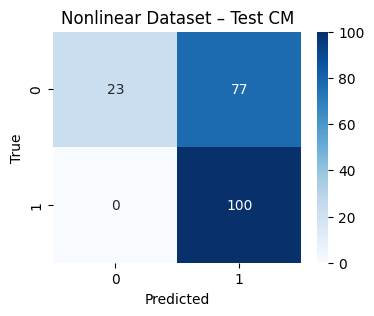

Test Accuracy: 0.615


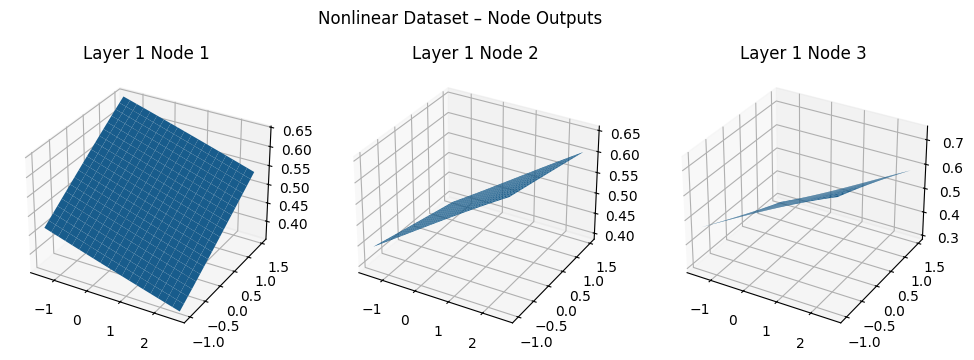

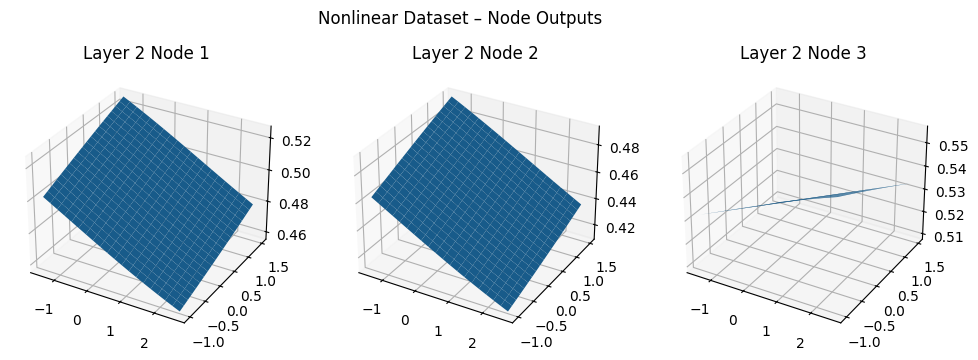

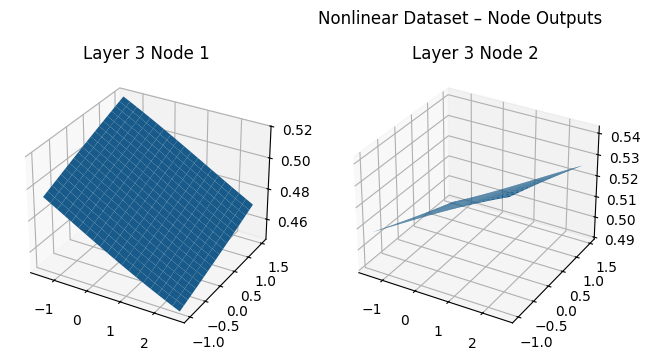

In [ ]:
datasets = [
    ("Linear Dataset", X1, y1, 3, [5, 10], 1),
    ("Nonlinear Dataset", X2, y2, 2, [8, 16], 2)
]

for name, X, y, C, nodes, hidden_layers in datasets:
    print(f"\n===== {name} =====")

    Xtr, ytr, Xv, yv, Xt, yt = get_data_split(X, y)

    best_acc, best_model, best_err = 0, None, None

    for h in nodes:
        arch = [2] + [h]*hidden_layers + [C]
        print("Architecture:", arch)

        model = FCNN(arch, lr=0.01)
        tr_err, _ = model.train_sgd(Xtr, ytr, Xv, yv)

        acc = accuracy_score(yv, model.predict(Xv))
        print("Validation Accuracy:", acc)

        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_err = tr_err

    plt.plot(best_err)
    plt.title(f"Error vs Epochs ({name})")
    plt.xlabel("Epochs")
    plt.ylabel("Squared Error")
    plt.show()

    plot_decision_boundary(best_model, Xtr, ytr, name)

    y_pred = best_model.predict(Xt)
    cm = confusion_matrix(yt, y_pred)
    plot_confusion(cm, f"{name} – Test CM")
    print("Test Accuracy:", accuracy_score(yt, y_pred))

    plot_3d_nodes(best_model, Xtr, f"{name} – Node Outputs")


In [ ]:
class Perceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        for _ in range(self.epochs):
            for xi, yi in zip(X, y):
                y_hat = 1 if np.dot(xi, self.w) + self.b >= 0 else 0
                self.w += self.lr * (yi - y_hat) * xi
                self.b += self.lr * (yi - y_hat)

    def predict(self, X):
        return np.array([1 if np.dot(xi, self.w) + self.b >= 0 else 0 for xi in X])


Xtr_p, ytr_p, Xv_p, yv_p, Xt_p, yt_p = get_data_split(X2, y2)

p = Perceptron(lr=0.01, epochs=50)
p.fit(Xtr_p, ytr_p)

p_pred = p.predict(Xt_p)
print("Perceptron Test Accuracy:", accuracy_score(yt_p, p_pred))



Perceptron Test Accuracy: 0.76
